# SVM – Wine Quality (binaire)

Ce notebook applique une **SVM (Support Vector Machine)** selon le cahier des charges :
- Séparer les classes binaires
- Nécessite normalisation (obligatoire)
- Classification binaire : quality ≥6 → bon, <6 → moyen/mauvais
- Évaluation avec Accuracy, F1-score
- Suivi avec MLflow

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
from preprocessing import load_data, clean_data, scale_features, split_data
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("sqlite:///c:/Users/pc/Desktop/ML-project/classification/mlflow.db")
mlflow.set_experiment("wine-quality-svm")

2026/02/14 17:16:07 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/14 17:16:07 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/14 17:16:07 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/14 17:16:07 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/14 17:16:07 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/14 17:16:07 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/14 17:16:08 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 17:16:08 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/classification/mlruns/5', creation_time=1770929539387, experiment_id='5', last_update_time=1770929539387, lifecycle_stage='active', name='wine-quality-svm', tags={}>

## 2. Chargement et preprocessing

In [2]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

# Cible binaire
df["quality_binary"] = (df["quality"] >= 6).astype(int)

X = df.drop(columns=["quality", "quality_binary"])
y = df["quality_binary"]

# Normalisation (obligatoire pour SVM)
X_scaled, scaler = scale_features(X)

# Train/test split
X_train, X_test, y_train, y_test = split_data(X_scaled, y, test_size=0.2, random_state=42)

print(f"Train set: {X_train.shape[0]} échantillons")
print(f"Test set: {X_test.shape[0]} échantillons")

Train set: 1087 échantillons
Test set: 272 échantillons


## 3. Test de différents kernels

Kernel linear: Accuracy=0.728, F1=0.734
Kernel rbf: Accuracy=0.754, F1=0.762
Kernel poly: Accuracy=0.743, F1=0.755


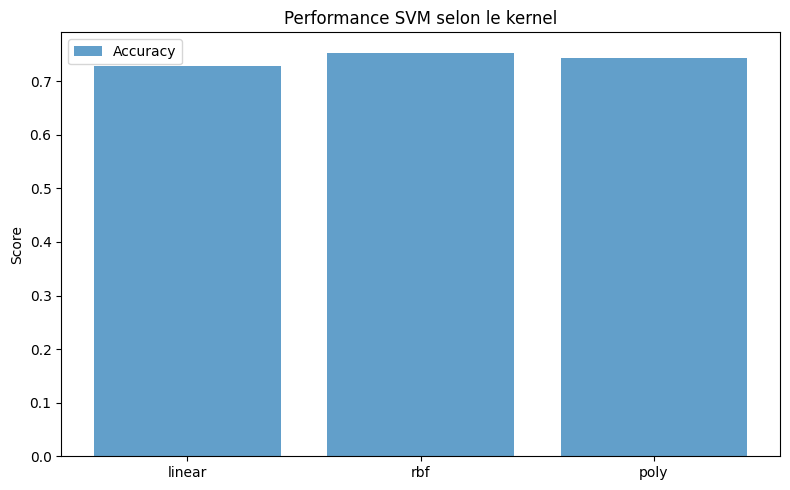

In [3]:
# Test de différents kernels
kernels = ['linear', 'rbf', 'poly']
results = []

for kernel in kernels:
    svm_test = SVC(kernel=kernel, probability=True, random_state=42)
    svm_test.fit(X_train, y_train)
    y_pred_test = svm_test.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    
    results.append({'kernel': kernel, 'accuracy': acc, 'f1': f1})
    print(f"Kernel {kernel}: Accuracy={acc:.3f}, F1={f1:.3f}")

# Visualisation
results_df = pd.DataFrame(results)
plt.figure(figsize=(8, 5))
x_pos = np.arange(len(kernels))
plt.bar(x_pos, results_df['accuracy'], alpha=0.7, label='Accuracy')
plt.xticks(x_pos, kernels)
plt.ylabel('Score')
plt.title('Performance SVM selon le kernel')
plt.legend()
plt.tight_layout()
plt.savefig("svm_kernels.png")
plt.show()

## 4. Entraînement avec kernel RBF (optimal)

In [4]:
# SVM avec kernel RBF
svm_clf = SVC(kernel="rbf", probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

# Métriques
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

Accuracy: 0.754
F1-score: 0.762
Precision: 0.781
Recall: 0.743

Matrice de confusion:
[[ 98  30]
 [ 37 107]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       128
           1       0.78      0.74      0.76       144

    accuracy                           0.75       272
   macro avg       0.75      0.75      0.75       272
weighted avg       0.76      0.75      0.75       272



## 5. Visualisation de la matrice de confusion

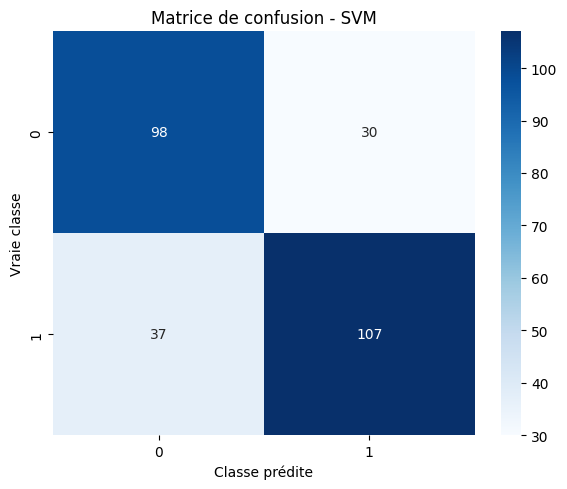

In [5]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion - SVM')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.savefig("svm_confusion_matrix.png")
plt.show()

## 6. MLflow tracking

In [6]:
with mlflow.start_run(run_name="SVM_rbf_binary"):
    mlflow.log_params(svm_clf.get_params())
    mlflow.log_metric("accuracy", float(acc))
    mlflow.log_metric("f1_score", float(f1))
    mlflow.log_metric("precision", float(precision))
    mlflow.log_metric("recall", float(recall))
    mlflow.log_artifact("svm_kernels.png")
    mlflow.log_artifact("svm_confusion_matrix.png")
    mlflow.sklearn.log_model(svm_clf, "svm_model")
    print("MLflow run terminé")

2026/02/14 17:16:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


MLflow run terminé
